In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import seaborn as sns
import time
import matplotlib.pyplot as plt
%matplotlib inline
# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In this kernel, I implement vectorized PDF caculation (without for loop) to get their correlation matrix. This is helpful to study feature grouping.
credits to @sibmike https://www.kaggle.com/sibmike/are-vars-mixed-up-time-intervals

**Functions**

In [36]:
def logloss(y,yp):
    yp = np.clip(yp,1e-5,1-1e-5)
    return -y*np.log(yp)-(1-y)*np.log(1-yp)
    
def reverse(tr,te):
    reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,138,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]
    reverse_list = ['var_%d'%i for i in reverse_list]
    for col in reverse_list:
        tr[col] = tr[col]*(-1)
        te[col] = te[col]*(-1)
    return tr,te

def scale(tr,te):
    for col in tr.columns:
        if col.startswith('var_'):
            mean,std = tr[col].mean(),tr[col].std()
            tr[col] = (tr[col]-mean)/std
            te[col] = (te[col]-mean)/std
    return tr,te

def getp_vec_sum(x,x_sort,y,std,c=0.5):
    # x is sorted
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

def get_pdf(tr,col,x_query=None,smooth=3):
    std = tr[col].std()
    df = tr.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    y,c = cols
    
    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()
    
    if x_query is None:
        rmin,rmax,res = -5.0, 5.0, 501
        x_query = np.linspace(rmin,rmax,res)
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query,df[col].values,df[y].values,std,c=smooth)
    cm = getp_vec_sum(x_query,df[col].values,df[c].values,std,c=smooth)+1
    dg['res'] = tm/cm
    dg.loc[cm<500,'res'] = 0.1
    return dg['res'].values

def get_pdfs(tr):
    y = []
    for i in range(200):
        name = 'var_%d'%i
        res = get_pdf(tr,name)
        y.append(res)
    return np.vstack(y)

def print_corr(corr_mat,col,bar=0.95):
    #print(col)
    cols = corr_mat.loc[corr_mat[col]>bar,col].index.values
    cols_ = ['var_%s'%(i.split('_')[-1]) for i in cols]
    print(col,"#####", cols)
    return cols

**load data & group vars**

In [3]:
%%time
path = '../input/'
tr = pd.read_csv('%s/train.csv'%path)
te = pd.read_csv('%s/test.csv'%path)

CPU times: user 15.7 s, sys: 2.84 s, total: 18.5 s
Wall time: 18.5 s


In [4]:
%%time
tr,te = reverse(tr,te)
tr,te = scale(tr,te)

CPU times: user 1.6 s, sys: 208 ms, total: 1.81 s
Wall time: 1.26 s


CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 85.6 ms


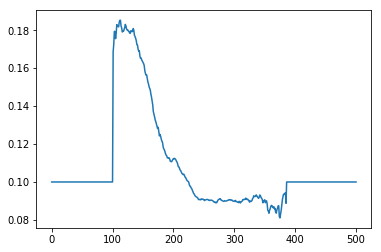

In [5]:
%%time
prob = get_pdf(tr,'var_0')
plt.plot(prob)

In [6]:
%%time
pdfs = get_pdfs(tr)

CPU times: user 11.8 s, sys: 84 ms, total: 11.9 s
Wall time: 11.7 s


In [7]:
%%time
df_pdf = pd.DataFrame(pdfs.T,columns=['var_prob_%d'%i for i in range(200)])
corr_mat = df_pdf.corr(method='pearson')

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 41.1 ms


In [8]:
corr_mat.head()

,var_prob_0,var_prob_1,var_prob_2,var_prob_3,var_prob_4,var_prob_5,var_prob_6,var_prob_7,var_prob_8,var_prob_9,var_prob_10,var_prob_11,var_prob_12,var_prob_13,var_prob_14,var_prob_15,var_prob_16,var_prob_17,var_prob_18,var_prob_19,var_prob_20,var_prob_21,var_prob_22,var_prob_23,var_prob_24,var_prob_25,var_prob_26,var_prob_27,var_prob_28,var_prob_29,var_prob_30,var_prob_31,var_prob_32,var_prob_33,var_prob_34,var_prob_35,var_prob_36,var_prob_37,var_prob_38,var_prob_39,...,var_prob_160,var_prob_161,var_prob_162,var_prob_163,var_prob_164,var_prob_165,var_prob_166,var_prob_167,var_prob_168,var_prob_169,var_prob_170,var_prob_171,var_prob_172,var_prob_173,var_prob_174,var_prob_175,var_prob_176,var_prob_177,var_prob_178,var_prob_179,var_prob_180,var_prob_181,var_prob_182,var_prob_183,var_prob_184,var_prob_185,var_prob_186,var_prob_187,var_prob_188,var_prob_189,var_prob_190,var_prob_191,var_prob_192,var_prob_193,var_prob_194,var_prob_195,var_prob_196,var_prob_197,var_prob_198,var_prob_199
var_prob_0,1.000000,0.854583,0.972078,0.799948,0.752191,0.866316,0.960129,0.237292,0.626824,0.870264,0.032000,0.925969,0.912165,0.927832,0.502256,0.837305,0.883415,-0.346605,0.912081,0.841877,0.607978,0.885942,0.933349,0.822009,0.852788,0.904557,0.978569,-0.021848,0.872660,0.614322,-0.044459,0.473049,0.815201,0.826957,0.874910,0.797903,0.873802,0.771386,0.153137,0.805864,...,0.587789,0.623052,0.958428,0.935764,0.725579,0.864072,0.882103,0.830568,0.892266,0.835027,0.921690,0.820164,0.875869,0.747450,0.980970,0.924158,0.676665,0.630832,0.774790,0.880749,0.848407,0.955273,0.585803,0.728471,0.914478,0.276258,0.544688,0.734017,0.772105,0.677138,0.904318,0.960480,0.607985,0.918069,0.766543,0.886770,0.735145,0.903237,0.962941,0.467118
var_prob_1,0.854583,1.000000,0.819273,0.864657,0.796191,0.980368,0.890947,0.328948,0.628785,0.929723,0.023516,0.815755,0.932628,0.876922,0.515117,0.983155,0.851748,-0.037313,0.890430,0.909239,0.628205,0.919860,0.788645,0.896657,0.970137,0.882013,0.888207,-0.081408,0.937612,0.570131,-0.015913,0.492299,0.922808,0.944419,0.976819,0.855830,0.918016,0.927526,0.273645,0.836748,...,0.617912,0.760213,0.897660,0.756367,0.798834,0.985498,0.964767,0.904355,0.697586,0.913235,0.772666,0.964851,0.878199,0.787160,0.865525,0.873952,0.763210,0.671183,0.839562,0.754363,0.979229,0.884672,0.721857,0.769639,0.820180,0.486839,0.497647,0.829812,0.849199,0.751612,0.940037,0.784764,0.607006,0.808662,0.871866,0.940488,0.801958,0.897400,0.858108,0.426958
var_prob_2,0.972078,0.819273,1.000000,0.775361,0.688469,0.828170,0.931483,0.207203,0.555155,0.842568,0.025634,0.906893,0.875644,0.903924,0.451703,0.806809,0.838761,-0.387666,0.886925,0.806989,0.542533,0.836240,0.959761,0.767212,0.813520,0.907867,0.947614,-0.056041,0.827657,0.592263,-0.075044,0.426451,0.761873,0.777878,0.834012,0.741570,0.822388,0.732950,0.150499,0.789714,...,0.520912,0.590801,0.930366,0.968937,0.665221,0.818853,0.845988,0.771493,0.950830,0.781505,0.944725,0.786969,0.823522,0.681257,0.960275,0.891968,0.626562,0.557928,0.716252,0.892242,0.807803,0.931628,0.561386,0.662207,0.899388,0.283711,0.477719,0.689990,0.715716,0.635369,0.862650,0.976321,0.558137,0.928784,0.715667,0.848215,0.674816,0.872410,0.935984,0.403145
var_prob_3,0.799948,0.864657,0.775361,1.000000,0.583454,0.856993,0.840764,0.283688,0.394153,0.936180,-0.342803,0.727916,0.904677,0.890953,0.255113,0.843089,0.806271,-0.121922,0.896236,0.868055,0.363414,0.809121,0.764313,0.689992,0.853832,0.740923,0.820245,-0.100831,0.795069,0.587201,0.073114,0.235144,0.775081,0.806080,0.864733,0.645864,0.793067,0.837783,0.229324,0.853947,...,0.465977,0.779931,0.885713,0.775139,0.627926,0.850751,0.916170,0.713548,0.658019,0.749607,0.729644,0.880839,0.730887,0.573666,0.829585,0.853242,0.693455,0.496999,0.631394,0.721341,0.837081,0.802117,0.730970,0.567678,0.836450,0.435079,0.277305,0.638297,0.665201,0.528748,0.865284,0.772524,0.381293,0.713788,0.739694,0.833402,0.603353,0.842384,0.849062,0.242511
var_prob_4,0.752191,0.796191,0.688469,0.583454,1.0000

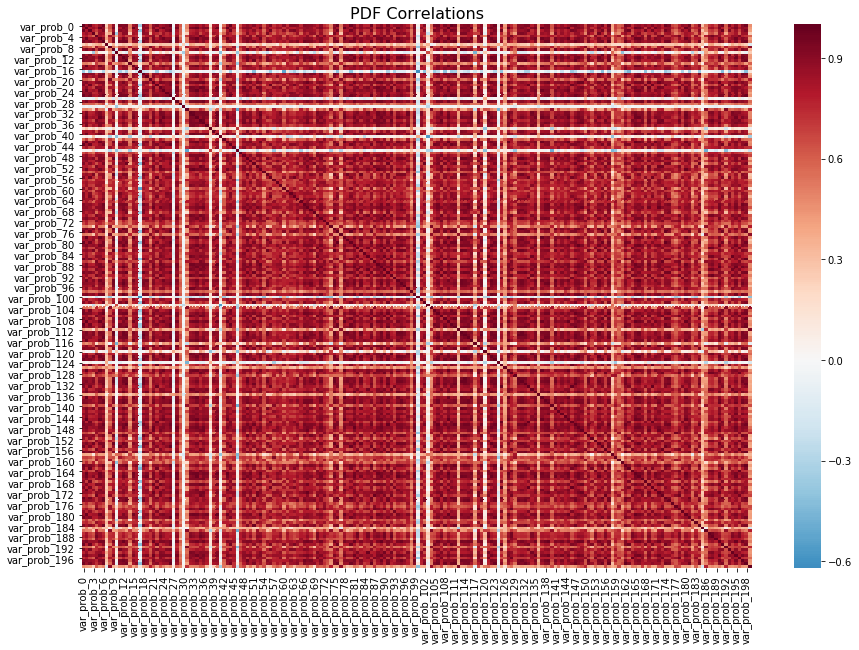

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_mat, cmap='RdBu_r', center=0.0) 
plt.title('PDF Correlations',fontsize=16)
plt.show() 

**We can group features using this correlation matrix. For example, var_0 and var_2's pdfs is 0.97+ correlated. We can confirm it using the figure below.**

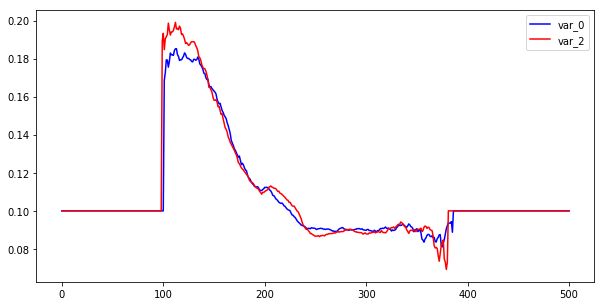

In [10]:
plt.figure(figsize=(10,5))
plt.plot(pdfs[0],color='b',label='var_0')
plt.plot(pdfs[2],color='r',label='var_2')
plt.legend(loc='upper right')

**We can find the group of a var using the following functions.**

In [11]:
cols = print_corr(corr_mat,'var_prob_12')
corr_mat.loc[cols,cols]

var_prob_12
['var_prob_12' 'var_prob_75' 'var_prob_81' 'var_prob_83' 'var_prob_89'
 'var_prob_95' 'var_prob_99' 'var_prob_113' 'var_prob_122' 'var_prob_139'
 'var_prob_154' 'var_prob_190']


,var_prob_12,var_prob_75,var_prob_81,var_prob_83,var_prob_89,var_prob_95,var_prob_99,var_prob_113,var_prob_122,var_prob_139,var_prob_154,var_prob_190
var_prob_12,1.000000,0.986023,0.974172,0.973832,0.986651,0.982335,0.995830,0.973779,0.977389,0.976521,0.971197,0.980504
var_prob_75,0.986023,1.000000,0.956044,0.988545,0.961934,0.968621,0.981870,0.979612,0.976348,0.951480,0.982545,0.956346
var_prob_81,0.974172,0.956044,1.000000,0.924456,0.972034,0.959667,0.973291,0.938961,0.975986,0.972479,0.967149,0.976072
var_prob_83,0.973832,0.988545,0.924456,1.000000,0.943665,0.957289,0.967895,0.977109,0.959866,0.931672,0.968721,0.933680
var_prob_89,0.986651,0.961934,0.972034,0.943665,1.000000,0.971942,0.989338,0.961916,0.974068,0.978463,0.954030,0.988728
var_prob_95,0.982335,0.968621,0.959667,0.957289,0.971942,1.000000,0.980663,0.961202,0.954215,0.972086,0.949408,0.968666
var_prob_99,0.995830,0.981870,0.973291,0.967895,0.989338,0.980663,1.000000,0.970514,0.979408,0.981130,0.969094,0.986252
var_prob_113,0.973779,0.979612,0.938961,0.977109,0.961916,0.961202,0.970514,1.000000,0.967848,0.938063,0.969930,0.948541
var_prob_122,0.977389,0.976348,0.975986,0.959866,0.974068,0.954215,0.979408,0.967848,1.000000,0.957901,0.990639,0.970853
var_prob_139,0.976521,0.951480,0.972479,0.931672,0.978463,0.972086,0.981130,0.938063,0.957901,1.000000,0.941614,0.983958


In [37]:
groups =[]
skip_list = []
for i in range(0,200):
    if(i not in skip_list):
        cols = print_corr(corr_mat,'var_prob_'+str(i))
        if(len(cols)>1):
            groups.append(cols)
            for e,v in enumerate(cols):
                skip_list.append(int(v[9:]))
print(len(groups))
    

var_prob_0 ##### ['var_prob_0' 'var_prob_2' 'var_prob_6' 'var_prob_26' 'var_prob_44'
 'var_prob_76' 'var_prob_80' 'var_prob_86' 'var_prob_106' 'var_prob_110'
 'var_prob_111' 'var_prob_123' 'var_prob_155' 'var_prob_157'
 'var_prob_162' 'var_prob_174' 'var_prob_181' 'var_prob_191'
 'var_prob_198']
var_prob_1 ##### ['var_prob_1' 'var_prob_5' 'var_prob_15' 'var_prob_24' 'var_prob_34'
 'var_prob_40' 'var_prob_43' 'var_prob_53' 'var_prob_78' 'var_prob_94'
 'var_prob_109' 'var_prob_116' 'var_prob_122' 'var_prob_127'
 'var_prob_137' 'var_prob_145' 'var_prob_165' 'var_prob_166'
 'var_prob_171' 'var_prob_180']
var_prob_3 ##### ['var_prob_3' 'var_prob_154']
var_prob_4 ##### ['var_prob_4' 'var_prob_35' 'var_prob_173' 'var_prob_188']
var_prob_7 ##### ['var_prob_7']
var_prob_8 ##### ['var_prob_8']
var_prob_9 ##### ['var_prob_9' 'var_prob_12' 'var_prob_49' 'var_prob_55' 'var_prob_75'
 'var_prob_79' 'var_prob_83' 'var_prob_94' 'var_prob_95' 'var_prob_99'
 'var_prob_113' 'var_prob_114' 'var_prob_122' '

In [48]:
for i,v in enumerate(groups):
    print(i,"########", v)

0 ######## ['var_prob_0' 'var_prob_2' 'var_prob_6' 'var_prob_26' 'var_prob_44'
 'var_prob_76' 'var_prob_80' 'var_prob_86' 'var_prob_106' 'var_prob_110'
 'var_prob_111' 'var_prob_123' 'var_prob_155' 'var_prob_157'
 'var_prob_162' 'var_prob_174' 'var_prob_181' 'var_prob_191'
 'var_prob_198']
1 ######## ['var_prob_1' 'var_prob_5' 'var_prob_15' 'var_prob_24' 'var_prob_34'
 'var_prob_40' 'var_prob_43' 'var_prob_53' 'var_prob_78' 'var_prob_94'
 'var_prob_109' 'var_prob_116' 'var_prob_122' 'var_prob_127'
 'var_prob_137' 'var_prob_145' 'var_prob_165' 'var_prob_166'
 'var_prob_171' 'var_prob_180']
2 ######## ['var_prob_3' 'var_prob_154']
3 ######## ['var_prob_4' 'var_prob_35' 'var_prob_173' 'var_prob_188']
4 ######## ['var_prob_9' 'var_prob_12' 'var_prob_49' 'var_prob_55' 'var_prob_75'
 'var_prob_79' 'var_prob_83' 'var_prob_94' 'var_prob_95' 'var_prob_99'
 'var_prob_113' 'var_prob_114' 'var_prob_122' 'var_prob_131'
 'var_prob_141' 'var_prob_154' 'var_prob_166']
5 ######## ['var_prob_11' 'var_pr

**Based on Probablity corelation, There seem to be 30 groups with more than one variable. There seem to be some groups with common members. **